In [1]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm
from scipy.linalg import svd, expm
import time
from numpy import linalg as LA
from scipy.linalg import hadamard, subspace_angles
from numpy.linalg import matrix_rank
import math

In [42]:
# Define functions

def gen_syn_data(M, N, dim_lat, nu):
    x = np.zeros((dim_lat + nu, 1))
    rho = 10  # Increasing rho increases excitation for better operator recovery
    Sigma = rho * np.eye(dim_lat + nu) + np.random.rand(dim_lat + nu, dim_lat + nu)
    Sigma_symm = ((1 / 2) * (Sigma + Sigma.T))
    Sigma_symm = ((dim_lat + nu) / np.trace(Sigma_symm)) * Sigma_symm
    X=[]
    Y=[]
    for i in range(N):
        X.append(sqrtm(Sigma_symm).dot(np.random.normal(0, 1, dim_lat + nu))) 
        w = np.random.normal(0, 1, 1)
        Y.append(M.dot(X[i]) + w)

    return X, Y


def subspace_distance(Phi_1, Phi_2):
    r = Phi_1.shape[0]
    distance = np.sqrt(r - np.linalg.norm(Phi_1.dot(Phi_2.T), 'fro') ** 2)
    return distance


def tasksgen(nx, nu, r, dim_lat, H, scale):
    # True representation
    Phi, _, _ = svd(np.random.randn(dim_lat + nu, dim_lat + nu))
    Phi = Phi[:r, :]

    F_0 = np.random.randn(1, nu + nx)  # Nominal task weights F
    M_0 = F_0.dot(Phi)  # Nominal operator M

    # Generating different tasks weights
    F = []
    P = []
    for h in range(1, H + 1):
        L = scale * np.random.randn(1, 1)
        F.append(L*F_0)  # Generating the true weights for H different tasks

    M = []
    for h in range(H):
        M.append(F[h].dot(Phi))  # Generating the true operators M for H different tasks
    return M, Phi



def grad_F(F,Phi,j,X,Y,lambda_F,ny,r,sigma):
    
    M = len(F)
    T = len(X)
    
    sum_term = 0
    
    for t in range(T):
        Phi_term = np.zeros([ny,r])
        Phi_term[j,:] = np.dot(Phi,X[t]).T
        
        sum_term = sum_term + (1/(sigma**2))*np.dot((Y[t] - np.dot(np.dot(F,Phi),X[t])).T,Phi_term)
    
    grad_weight = -(F[:,j])/(lambda_F**2) + sum_term
    
    return grad_weight


def grad_Phi(F,Phi,j,Xc,Yc,lambda_Phi,sigma):
    
    M = len(F)
    T = len(Xc)
    
    sum_term = 0
    
    for i in range(M): 
        for t in range(T):
            X = np.zeros([Xc[i][t].shape[0],1])
            X[:,0] = Xc[i][t]
            sum_term = sum_term + (1/(sigma**2))*np.dot(F[i].T,Yc[i][t]-np.dot(np.dot(F[i],Phi),X))*X[j,0]
    
    #Gaussian Prior
    grad_phi = np.zeros([r,1])
    grad_phi[:,0] = Phi[:,j]      
    grad_phi=-grad_phi/(lambda_phi**2) + sum_term
    
    
    
    #Laplace Prior
    #grad_phi = np.zeros([r,1])
    #for i in range(r):
    #    if Phi[:,j][i] <= 0:
    #        grad_phi[i,0] = -1
    #    else:
    #        grad_phi[i,0] = 1
    
   
    grad_phi=-grad_phi/(lambda_phi) + sum_term
    
    return grad_phi

def log_joint(F,Phi,Yc,Xc,lambda_phi,lambda_F,nx,ny,sigma):
    
    M = len(F)
    T = len(Xc)
    
    sum_term = 0
    
    for i in range(M):
        for t in range(T):
            X = np.zeros([Xc[i][t].shape[0],1])
            X[:,0] = Xc[i][t]
            sum_term = sum_term  - (1/2*(sigma**2))*(Yc[i][t] - np.dot(np.dot(F[i],Phi),X))**2
        
        sum_term = sum_term -(LA.norm(F[i], 2)**2)/(2*(lambda_F)**2)
    
    for j in range(nx):
        sum_term = sum_term - (1/2)*(lambda_phi**2)*(LA.norm(Phi_hat[:,j], 1)**2)
    
    return sum_term[0][0]



def CAMAP(Phi_hat, F, K, H, M, Phi_true, nx, nu, N, dim_lat, lambda_phi, lambda_F, eta_F, eta_phi, sigma, X, Y):
    

    r = nx + nu

    Error_rep = []
    Log_joint_iter = []
    
    for k in range(K):
        start_time = time.time()
        
        # Calculating subspace distance
        Error_rep.append(subspace_distance(Phi_true, Phi_hat))
        if math.isnan(Error_rep[k]):
            break 
        
       
        Xc=[]
        Yc=[]
        
        for h in range(H): # For all tasks do
           
            for j in range(ny):
                F[h][:] = F[h][:] + eta_F*grad_F(F[h],Phi_hat,int(j),X[h],Y[h],lambda_F,ny,r,sigma)
                
        for j in range(nx):
            Phi_hat[:,j] = Phi_hat[:,j] + (eta_phi)*grad_Phi(F,Phi_hat,int(j),X,Y,lambda_phi,sigma)[:,0]
        
        eta_phi = eta_phi/1.001
        
        
        Log_joint_iter.append(log_joint(F,Phi_hat,Y,X,lambda_phi,lambda_F,nx,ny,sigma))

        
        end_time = time.time()
        print(f"Iteration: {k}, Subspace Dist: {Error_rep[k]}, Time: {end_time - start_time}")
        
    return Error_rep, Log_joint_iter, Phi_hat, F


In [3]:
def tasksgen(nx, nu, r, dim_lat, H, scale):
    # True representation
    Phi, _, _ = svd(np.random.randn(dim_lat + nu, dim_lat + nu))
    Phi = Phi[:r, :]
    
    #Generating a sparse representation
    Phi_true_sparse = np.zeros([Phi.shape[0],Phi.shape[1]])

    for i in range(Phi.shape[0]):
        for j in range(Phi.shape[1]):
            if Phi[i,j]<=0:
                Phi_true_sparse[i,j] = 0
            else:
                Phi_true_sparse[i,j] = Phi[i,j]

    Phi = Phi_true_sparse
    
    
    
    F_0 = np.random.randn(1, nu + nx)  # Nominal task weights F
    M_0 = F_0.dot(Phi)  # Nominal operator M

    # Generating different tasks weights
    F = []
    P = []
    for h in range(1, H + 1):
        L = scale * np.random.randn(1, 1)
        F.append(L*F_0)  # Generating the true weights for H different tasks

    M = []
    for h in range(H):
        M.append(F[h].dot(Phi))  # Generating the true operators M for H different tasks
    return M, Phi

$\textbf{System Parameter:}$

In [4]:
# System dimensions
nx = 5
nu = 2
r = nx + nu  # rank
dim_lat = 50  # dimension of the latent space
H = 20 # number of tasks
scale = 0.001  # scale of rotation
N = 100
lambda_F = 1


M, Phi_true = tasksgen(nx, nu, r, dim_lat, H, scale)

np.save('seed', {"M_list": M, "Phi_true": Phi_true})

#Initializing the representation
L = np.random.randn(dim_lat + nu, dim_lat + nu)
skewL = (L - L.T) / 2
rot = expm(skewL)

ny = 1 #Linear regression
    
F = []
for h in range(H):
    F_i = np.zeros([ny,r])
    for i in range(ny):
        for j in range(r):
            F_i[i,j] = np.random.normal(loc=0, scale=lambda_F)
    F.append(F_i)

X = []
Y = []
for h in range(H):
    [X_h,Y_h] = gen_syn_data(M[h], N, dim_lat, nu)
    X.append(X_h)
    Y.append(Y_h)

$\textbf{Coordinate Ascent MAP Estimation:}$

In [39]:
K = 5000 # number of global iterations
N = 100  # number of samples

lambda_phi = 100
sigma = 0.25

eta_F = 0.00001
eta_phi = 0.000895

Phi_hat = Phi_true.dot(rot)

In [43]:
H = 10
F_init = []
X_data = []
Y_data = []

for i in range(H):
    F_init.append(F[i])
    X_data.append(X[i])
    Y_data.append(Y[i])

Phi_hat = Phi_true.dot(rot)
Error_CAMAP_1_s, _ , Phi_MAP, _ = CAMAP(Phi_hat, F_init, K, H, M, Phi_true, nx, nu, N, dim_lat, lambda_phi, lambda_F, eta_F, eta_phi,sigma, X_data, Y_data)

Iteration: 0, Subspace Dist: 2.6122640082674398, Time: 0.02992081642150879
Iteration: 1, Subspace Dist: 2.61253610729934, Time: 0.01698899269104004
Iteration: 2, Subspace Dist: 2.6126977156507047, Time: 0.015957355499267578
Iteration: 3, Subspace Dist: 2.612772652431079, Time: 0.016957759857177734
Iteration: 4, Subspace Dist: 2.6127786810526525, Time: 0.01735711097717285
Iteration: 5, Subspace Dist: 2.6127291270776265, Time: 0.01699090003967285
Iteration: 6, Subspace Dist: 2.6126340310625618, Time: 0.017917394638061523
Iteration: 7, Subspace Dist: 2.6125009802116312, Time: 0.015955686569213867
Iteration: 8, Subspace Dist: 2.6123357146918225, Time: 0.01695418357849121
Iteration: 9, Subspace Dist: 2.612142573767729, Time: 0.01894974708557129
Iteration: 10, Subspace Dist: 2.611924826802199, Time: 0.01795172691345215
Iteration: 11, Subspace Dist: 2.6116849207176625, Time: 0.016956806182861328
Iteration: 12, Subspace Dist: 2.61142466635238, Time: 0.023933887481689453
Iteration: 13, Subspace

Iteration: 115, Subspace Dist: 2.5043489512937307, Time: 0.019945621490478516
Iteration: 116, Subspace Dist: 2.502917086087428, Time: 0.01894831657409668
Iteration: 117, Subspace Dist: 2.501483390264449, Time: 0.016954898834228516
Iteration: 118, Subspace Dist: 2.500047975521509, Time: 0.017953872680664062
Iteration: 119, Subspace Dist: 2.49861094988347, Time: 0.01599407196044922
Iteration: 120, Subspace Dist: 2.497172417509222, Time: 0.01791524887084961
Iteration: 121, Subspace Dist: 2.4957324785275565, Time: 0.01698756217956543
Iteration: 122, Subspace Dist: 2.494291228902493, Time: 0.018949031829833984
Iteration: 123, Subspace Dist: 2.492848760327226, Time: 0.01792001724243164
Iteration: 124, Subspace Dist: 2.4914051601456637, Time: 0.018981218338012695
Iteration: 125, Subspace Dist: 2.48996051130034, Time: 0.018081188201904297
Iteration: 126, Subspace Dist: 2.4885148923053197, Time: 0.02293872833251953
Iteration: 127, Subspace Dist: 2.487068377242606, Time: 0.019946813583374023
Ite

Iteration: 224, Subspace Dist: 2.3449118007998617, Time: 0.024933815002441406
Iteration: 225, Subspace Dist: 2.343426812330124, Time: 0.017951488494873047
Iteration: 226, Subspace Dist: 2.341941636230548, Time: 0.01894974708557129
Iteration: 227, Subspace Dist: 2.340456291682789, Time: 0.016956329345703125
Iteration: 228, Subspace Dist: 2.338970798222384, Time: 0.015955209732055664
Iteration: 229, Subspace Dist: 2.3374851757210955, Time: 0.01695394515991211
Iteration: 230, Subspace Dist: 2.335999444369301, Time: 0.017950773239135742
Iteration: 231, Subspace Dist: 2.3345136246584595, Time: 0.020073413848876953
Iteration: 232, Subspace Dist: 2.3330277373636883, Time: 0.019977807998657227
Iteration: 233, Subspace Dist: 2.3315418035264712, Time: 0.020913362503051758
Iteration: 234, Subspace Dist: 2.3300558444375326, Time: 0.020073652267456055
Iteration: 235, Subspace Dist: 2.3285698816198934, Time: 0.023937463760375977
Iteration: 236, Subspace Dist: 2.327083936812136, Time: 0.0199465751647

Iteration: 336, Subspace Dist: 2.1822107139645186, Time: 0.026928186416625977
Iteration: 337, Subspace Dist: 2.1808283855333874, Time: 0.018963336944580078
Iteration: 338, Subspace Dist: 2.179447757221198, Time: 0.017937898635864258
Iteration: 339, Subspace Dist: 2.1780688345736468, Time: 0.01796412467956543
Iteration: 340, Subspace Dist: 2.1766916229430677, Time: 0.017940521240234375
Iteration: 341, Subspace Dist: 2.1753161274908885, Time: 0.017986774444580078
Iteration: 342, Subspace Dist: 2.173942353190105, Time: 0.016919851303100586
Iteration: 343, Subspace Dist: 2.1725703048277745, Time: 0.017953157424926758
Iteration: 344, Subspace Dist: 2.1711999870075207, Time: 0.017979860305786133
Iteration: 345, Subspace Dist: 2.1698314041520557, Time: 0.01692509651184082
Iteration: 346, Subspace Dist: 2.1684645605057113, Time: 0.016986608505249023
Iteration: 347, Subspace Dist: 2.167099460136983, Time: 0.01792144775390625
Iteration: 348, Subspace Dist: 2.1657361069410785, Time: 0.02094411849

Iteration: 453, Subspace Dist: 2.0324241672567105, Time: 0.020946979522705078
Iteration: 454, Subspace Dist: 2.0312452212657615, Time: 0.019945144653320312
Iteration: 455, Subspace Dist: 2.03006787987847, Time: 0.01798415184020996
Iteration: 456, Subspace Dist: 2.028892139217016, Time: 0.016953706741333008
Iteration: 457, Subspace Dist: 2.0277179953797795, Time: 0.01596212387084961
Iteration: 458, Subspace Dist: 2.026545444441478, Time: 0.016918659210205078
Iteration: 459, Subspace Dist: 2.025374482453293, Time: 0.017950773239135742
Iteration: 460, Subspace Dist: 2.0242051054429986, Time: 0.01795339584350586
Iteration: 461, Subspace Dist: 2.0230373094150704, Time: 0.016953229904174805
Iteration: 462, Subspace Dist: 2.021871090350805, Time: 0.01795339584350586
Iteration: 463, Subspace Dist: 2.020706444208422, Time: 0.01795220375061035
Iteration: 464, Subspace Dist: 2.0195433669231684, Time: 0.026927709579467773
Iteration: 465, Subspace Dist: 2.0183818544074152, Time: 0.01795053482055664

Iteration: 569, Subspace Dist: 1.9052366857444412, Time: 0.022940397262573242
Iteration: 570, Subspace Dist: 1.9042130378211302, Time: 0.01795196533203125
Iteration: 571, Subspace Dist: 1.9031904322621154, Time: 0.018949270248413086
Iteration: 572, Subspace Dist: 1.9021688641185805, Time: 0.01695394515991211
Iteration: 573, Subspace Dist: 1.9011483284664978, Time: 0.01595592498779297
Iteration: 574, Subspace Dist: 1.9001288204075604, Time: 0.015958309173583984
Iteration: 575, Subspace Dist: 1.8991103350701133, Time: 0.017951488494873047
Iteration: 576, Subspace Dist: 1.8980928676100903, Time: 0.016956329345703125
Iteration: 577, Subspace Dist: 1.89707641321195, Time: 0.01795029640197754
Iteration: 578, Subspace Dist: 1.8960609670896154, Time: 0.015958786010742188
Iteration: 579, Subspace Dist: 1.8950465244874122, Time: 0.0169525146484375
Iteration: 580, Subspace Dist: 1.8940330806810102, Time: 0.023937463760375977
Iteration: 581, Subspace Dist: 1.8930206309783622, Time: 0.0189495086669

Iteration: 678, Subspace Dist: 1.7989894395849892, Time: 0.023936986923217773
Iteration: 679, Subspace Dist: 1.798059719291949, Time: 0.018949031829833984
Iteration: 680, Subspace Dist: 1.797130784506807, Time: 0.016953706741333008
Iteration: 681, Subspace Dist: 1.7962026355052787, Time: 0.016994953155517578
Iteration: 682, Subspace Dist: 1.7952752725768015, Time: 0.01595759391784668
Iteration: 683, Subspace Dist: 1.7943486960226969, Time: 0.015921354293823242
Iteration: 684, Subspace Dist: 1.793422906154324, Time: 0.017953872680664062
Iteration: 685, Subspace Dist: 1.7924979032912114, Time: 0.01795196533203125
Iteration: 686, Subspace Dist: 1.7915736877591788, Time: 0.018982887268066406
Iteration: 687, Subspace Dist: 1.7906502598884435, Time: 0.0169525146484375
Iteration: 688, Subspace Dist: 1.7897276200117151, Time: 0.01696157455444336
Iteration: 689, Subspace Dist: 1.7888057684622816, Time: 0.015918254852294922
Iteration: 690, Subspace Dist: 1.7878847055720855, Time: 0.0229036808013

Iteration: 792, Subspace Dist: 1.697965128562931, Time: 0.02293848991394043
Iteration: 793, Subspace Dist: 1.697119219498873, Time: 0.017952680587768555
Iteration: 794, Subspace Dist: 1.6962738729073323, Time: 0.017981290817260742
Iteration: 795, Subspace Dist: 1.6954290839476065, Time: 0.017921924591064453
Iteration: 796, Subspace Dist: 1.6945848477764598, Time: 0.017986059188842773
Iteration: 797, Subspace Dist: 1.6937411595506666, Time: 0.01692056655883789
Iteration: 798, Subspace Dist: 1.692898014429551, Time: 0.016986608505249023
Iteration: 799, Subspace Dist: 1.6920554075775525, Time: 0.018917322158813477
Iteration: 800, Subspace Dist: 1.6912133341667892, Time: 0.01798415184020996
Iteration: 801, Subspace Dist: 1.6903717893796324, Time: 0.019947052001953125
Iteration: 802, Subspace Dist: 1.6895307684112835, Time: 0.020943641662597656
Iteration: 803, Subspace Dist: 1.6886902664723529, Time: 0.019946813583374023
Iteration: 804, Subspace Dist: 1.6878502787914385, Time: 0.02390956878

Iteration: 908, Subspace Dist: 1.6026913115752004, Time: 0.026926517486572266
Iteration: 909, Subspace Dist: 1.6018918121498769, Time: 0.01699042320251465
Iteration: 910, Subspace Dist: 1.6010927195674256, Time: 0.01696038246154785
Iteration: 911, Subspace Dist: 1.6002940363110414, Time: 0.015954017639160156
Iteration: 912, Subspace Dist: 1.5994957648778712, Time: 0.01595759391784668
Iteration: 913, Subspace Dist: 1.5986979077771801, Time: 0.01595759391784668
Iteration: 914, Subspace Dist: 1.597900467528533, Time: 0.015919923782348633
Iteration: 915, Subspace Dist: 1.5971034466600145, Time: 0.01795363426208496
Iteration: 916, Subspace Dist: 1.5963068477064644, Time: 0.01699519157409668
Iteration: 917, Subspace Dist: 1.5955106732077515, Time: 0.017911672592163086
Iteration: 918, Subspace Dist: 1.5947149257070703, Time: 0.01698756217956543
Iteration: 919, Subspace Dist: 1.5939196077492725, Time: 0.01592278480529785
Iteration: 920, Subspace Dist: 1.5931247218792264, Time: 0.02112388610839

Iteration: 1014, Subspace Dist: 1.5206286625580163, Time: 0.019946813583374023
Iteration: 1015, Subspace Dist: 1.5198831362395029, Time: 0.021909236907958984
Iteration: 1016, Subspace Dist: 1.5191381718969632, Time: 0.016954660415649414
Iteration: 1017, Subspace Dist: 1.5183937696133727, Time: 0.016954898834228516
Iteration: 1018, Subspace Dist: 1.5176499294568684, Time: 0.016986370086669922
Iteration: 1019, Subspace Dist: 1.5169066514811884, Time: 0.015974044799804688
Iteration: 1020, Subspace Dist: 1.5161639357261, Time: 0.017904996871948242
Iteration: 1021, Subspace Dist: 1.5154217822178258, Time: 0.016952991485595703
Iteration: 1022, Subspace Dist: 1.514680190969465, Time: 0.015995025634765625
Iteration: 1023, Subspace Dist: 1.513939161981404, Time: 0.01595473289489746
Iteration: 1024, Subspace Dist: 1.5131986952417233, Time: 0.015958547592163086
Iteration: 1025, Subspace Dist: 1.5124587907265978, Time: 0.015957355499267578
Iteration: 1026, Subspace Dist: 1.5117194484006906, Time: 

Iteration: 1120, Subspace Dist: 1.444704385372788, Time: 0.02297353744506836
Iteration: 1121, Subspace Dist: 1.4440174524566314, Time: 0.016956567764282227
Iteration: 1122, Subspace Dist: 1.443331055439227, Time: 0.0169527530670166
Iteration: 1123, Subspace Dist: 1.442645193862519, Time: 0.016919851303100586
Iteration: 1124, Subspace Dist: 1.4419598672618172, Time: 0.01599574089050293
Iteration: 1125, Subspace Dist: 1.4412750751656451, Time: 0.015954971313476562
Iteration: 1126, Subspace Dist: 1.4405908170955861, Time: 0.015957355499267578
Iteration: 1127, Subspace Dist: 1.4399070925661306, Time: 0.01595592498779297
Iteration: 1128, Subspace Dist: 1.439223901084521, Time: 0.016956806182861328
Iteration: 1129, Subspace Dist: 1.4385412421505948, Time: 0.017915010452270508
Iteration: 1130, Subspace Dist: 1.4378591152566302, Time: 0.016952991485595703
Iteration: 1131, Subspace Dist: 1.4371775198871966, Time: 0.017954111099243164
Iteration: 1132, Subspace Dist: 1.4364964555189919, Time: 0.0

Iteration: 1227, Subspace Dist: 1.3741011090742463, Time: 0.020909786224365234
Iteration: 1228, Subspace Dist: 1.3734668801724512, Time: 0.020943403244018555
Iteration: 1229, Subspace Dist: 1.3728330743397759, Time: 0.017950057983398438
Iteration: 1230, Subspace Dist: 1.372199689748497, Time: 0.017953872680664062
Iteration: 1231, Subspace Dist: 1.3715667245557022, Time: 0.01795029640197754
Iteration: 1232, Subspace Dist: 1.3709341769033405, Time: 0.018981456756591797
Iteration: 1233, Subspace Dist: 1.3703020449182661, Time: 0.01792144775390625
Iteration: 1234, Subspace Dist: 1.3696703267122938, Time: 0.016984939575195312
Iteration: 1235, Subspace Dist: 1.369039020382257, Time: 0.01795220375061035
Iteration: 1236, Subspace Dist: 1.3684081240100592, Time: 0.01891922950744629
Iteration: 1237, Subspace Dist: 1.3677776356627387, Time: 0.01699066162109375
Iteration: 1238, Subspace Dist: 1.3671475533925297, Time: 0.020938396453857422
Iteration: 1239, Subspace Dist: 1.3665178752369305, Time: 0

Iteration: 1332, Subspace Dist: 1.3094106230138511, Time: 0.023934125900268555
Iteration: 1333, Subspace Dist: 1.3088084707483105, Time: 0.017984867095947266
Iteration: 1334, Subspace Dist: 1.3082064881510498, Time: 0.01695394515991211
Iteration: 1335, Subspace Dist: 1.3076046725463275, Time: 0.01792144775390625
Iteration: 1336, Subspace Dist: 1.3070030212620485, Time: 0.018949270248413086
Iteration: 1337, Subspace Dist: 1.30640153163005, Time: 0.01595616340637207
Iteration: 1338, Subspace Dist: 1.305800200986397, Time: 0.016956329345703125
Iteration: 1339, Subspace Dist: 1.3051990266716713, Time: 0.018949270248413086
Iteration: 1340, Subspace Dist: 1.304598006031266, Time: 0.01695537567138672
Iteration: 1341, Subspace Dist: 1.303997136415679, Time: 0.017015695571899414
Iteration: 1342, Subspace Dist: 1.303396415180808, Time: 0.01797771453857422
Iteration: 1343, Subspace Dist: 1.302795839688244, Time: 0.016000032424926758
Iteration: 1344, Subspace Dist: 1.302195407305571, Time: 0.02392

Iteration: 1441, Subspace Dist: 1.2442672613752879, Time: 0.024934053421020508
Iteration: 1442, Subspace Dist: 1.2436702172789997, Time: 0.021941661834716797
Iteration: 1443, Subspace Dist: 1.2430731312786611, Time: 0.017983198165893555
Iteration: 1444, Subspace Dist: 1.2424760026293495, Time: 0.01595783233642578
Iteration: 1445, Subspace Dist: 1.241878830612431, Time: 0.016955137252807617
Iteration: 1446, Subspace Dist: 1.2412816145355512, Time: 0.0159604549407959
Iteration: 1447, Subspace Dist: 1.2406843537326022, Time: 0.01694798469543457
Iteration: 1448, Subspace Dist: 1.2400870475636938, Time: 0.01696157455444336
Iteration: 1449, Subspace Dist: 1.2394896954151233, Time: 0.016918182373046875
Iteration: 1450, Subspace Dist: 1.2388922966993272, Time: 0.016956567764282227
Iteration: 1451, Subspace Dist: 1.2382948508548335, Time: 0.017949819564819336
Iteration: 1452, Subspace Dist: 1.2376973573462131, Time: 0.016956806182861328
Iteration: 1453, Subspace Dist: 1.2370998156640156, Time: 

Iteration: 1548, Subspace Dist: 1.180122018942479, Time: 0.02197122573852539
Iteration: 1549, Subspace Dist: 1.1795208325130961, Time: 0.02430558204650879
Iteration: 1550, Subspace Dist: 1.1789196440606047, Time: 0.03490614891052246
Iteration: 1551, Subspace Dist: 1.178318454631839, Time: 0.02593064308166504
Iteration: 1552, Subspace Dist: 1.1777172652758376, Time: 0.025931119918823242
Iteration: 1553, Subspace Dist: 1.1771160770435802, Time: 0.018053770065307617
Iteration: 1554, Subspace Dist: 1.1765148909877197, Time: 0.016954660415649414
Iteration: 1555, Subspace Dist: 1.1759137081623228, Time: 0.017953157424926758
Iteration: 1556, Subspace Dist: 1.1753125296226052, Time: 0.016060829162597656
Iteration: 1557, Subspace Dist: 1.17471135642468, Time: 0.02393651008605957
Iteration: 1558, Subspace Dist: 1.1741101896253, Time: 0.018950223922729492
Iteration: 1559, Subspace Dist: 1.1735090302816025, Time: 0.016990184783935547
Iteration: 1560, Subspace Dist: 1.1729078794508678, Time: 0.0159

Iteration: 1656, Subspace Dist: 1.1153837893629228, Time: 0.022938013076782227
Iteration: 1657, Subspace Dist: 1.114787797930368, Time: 0.01809215545654297
Iteration: 1658, Subspace Dist: 1.114191892696915, Time: 0.01695394515991211
Iteration: 1659, Subspace Dist: 1.1135960740600093, Time: 0.01610398292541504
Iteration: 1660, Subspace Dist: 1.1130003424090236, Time: 0.018868684768676758
Iteration: 1661, Subspace Dist: 1.112404698125307, Time: 0.016954660415649414
Iteration: 1662, Subspace Dist: 1.111809141582248, Time: 0.015990495681762695
Iteration: 1663, Subspace Dist: 1.1112136731453326, Time: 0.01592564582824707
Iteration: 1664, Subspace Dist: 1.1106182931722126, Time: 0.01695394515991211
Iteration: 1665, Subspace Dist: 1.1100230020127684, Time: 0.016956329345703125
Iteration: 1666, Subspace Dist: 1.109427800009172, Time: 0.01795053482055664
Iteration: 1667, Subspace Dist: 1.108832687495958, Time: 0.016956090927124023
Iteration: 1668, Subspace Dist: 1.1082376648000933, Time: 0.0209

Iteration: 1761, Subspace Dist: 1.0533187607552434, Time: 0.02709341049194336
Iteration: 1762, Subspace Dist: 1.0527328617662586, Time: 0.017981767654418945
Iteration: 1763, Subspace Dist: 1.0521470623512144, Time: 0.016961336135864258
Iteration: 1764, Subspace Dist: 1.0515613625398306, Time: 0.017950773239135742
Iteration: 1765, Subspace Dist: 1.0509757623633935, Time: 0.01595783233642578
Iteration: 1766, Subspace Dist: 1.0503902618548449, Time: 0.016690492630004883
Iteration: 1767, Subspace Dist: 1.0498048610488686, Time: 0.01609659194946289
Iteration: 1768, Subspace Dist: 1.0492195599819736, Time: 0.015955209732055664
Iteration: 1769, Subspace Dist: 1.04863435869258, Time: 0.016919612884521484
Iteration: 1770, Subspace Dist: 1.0480492572211026, Time: 0.0169527530670166
Iteration: 1771, Subspace Dist: 1.0474642556100346, Time: 0.016956329345703125
Iteration: 1772, Subspace Dist: 1.04687935390403, Time: 0.016954898834228516
Iteration: 1773, Subspace Dist: 1.0462945521499858, Time: 0.0

Iteration: 1867, Subspace Dist: 0.9917887406830855, Time: 0.018982648849487305
Iteration: 1868, Subspace Dist: 0.9912142251037621, Time: 0.019045352935791016
Iteration: 1869, Subspace Dist: 0.9906398342143009, Time: 0.017950057983398438
Iteration: 1870, Subspace Dist: 0.9900655685546381, Time: 0.017952680587768555
Iteration: 1871, Subspace Dist: 0.9894914286713392, Time: 0.01722431182861328
Iteration: 1872, Subspace Dist: 0.9889174151175951, Time: 0.020154237747192383
Iteration: 1873, Subspace Dist: 0.9883435284532313, Time: 0.01795196533203125
Iteration: 1874, Subspace Dist: 0.9877697692447066, Time: 0.01798415184020996
Iteration: 1875, Subspace Dist: 0.9871961380651167, Time: 0.016953468322753906
Iteration: 1876, Subspace Dist: 0.9866226354941886, Time: 0.015926599502563477
Iteration: 1877, Subspace Dist: 0.9860492621182879, Time: 0.01595759391784668
Iteration: 1878, Subspace Dist: 0.9854760185304081, Time: 0.01699090003967285
Iteration: 1879, Subspace Dist: 0.9849029053301763, Time:

Iteration: 1977, Subspace Dist: 0.9294929257046658, Time: 0.021976947784423828
Iteration: 1978, Subspace Dist: 0.9289367094411698, Time: 0.016957521438598633
Iteration: 1979, Subspace Dist: 0.9283807129032121, Time: 0.01694655418395996
Iteration: 1980, Subspace Dist: 0.9278249372036851, Time: 0.02191758155822754
Iteration: 1981, Subspace Dist: 0.927269383457799, Time: 0.022971391677856445
Iteration: 1982, Subspace Dist: 0.9267140527830139, Time: 0.019915103912353516
Iteration: 1983, Subspace Dist: 0.9261589462989709, Time: 0.02293848991394043
Iteration: 1984, Subspace Dist: 0.9256040651274142, Time: 0.018982648849487305
Iteration: 1985, Subspace Dist: 0.9250494103921206, Time: 0.019912242889404297
Iteration: 1986, Subspace Dist: 0.9244949832188274, Time: 0.018980979919433594
Iteration: 1987, Subspace Dist: 0.9239407847351554, Time: 0.019943952560424805
Iteration: 1988, Subspace Dist: 0.9233868160705416, Time: 0.022911548614501953
Iteration: 1989, Subspace Dist: 0.9228330783561596, Time

Iteration: 2082, Subspace Dist: 0.8725024751748011, Time: 0.020943403244018555
Iteration: 2083, Subspace Dist: 0.8719754872145432, Time: 0.018949508666992188
Iteration: 2084, Subspace Dist: 0.8714488346719222, Time: 0.017986774444580078
Iteration: 2085, Subspace Dist: 0.8709225185069708, Time: 0.016949892044067383
Iteration: 2086, Subspace Dist: 0.8703965396748394, Time: 0.01596379280090332
Iteration: 2087, Subspace Dist: 0.8698708991257535, Time: 0.017038345336914062
Iteration: 2088, Subspace Dist: 0.8693455978049571, Time: 0.016956090927124023
Iteration: 2089, Subspace Dist: 0.8688206366526756, Time: 0.017950773239135742
Iteration: 2090, Subspace Dist: 0.8682960166040615, Time: 0.017953157424926758
Iteration: 2091, Subspace Dist: 0.8677717385891489, Time: 0.016953229904174805
Iteration: 2092, Subspace Dist: 0.8672478035328092, Time: 0.01795363426208496
Iteration: 2093, Subspace Dist: 0.8667242123547079, Time: 0.01708817481994629
Iteration: 2094, Subspace Dist: 0.8662009659692563, Tim

Iteration: 2190, Subspace Dist: 0.8176914220584621, Time: 0.0189816951751709
Iteration: 2191, Subspace Dist: 0.8172050182058098, Time: 0.01814746856689453
Iteration: 2192, Subspace Dist: 0.816719018634874, Time: 0.016954660415649414
Iteration: 2193, Subspace Dist: 0.8162334236227407, Time: 0.01795220375061035
Iteration: 2194, Subspace Dist: 0.8157482334398337, Time: 0.017120361328125
Iteration: 2195, Subspace Dist: 0.8152634483499186, Time: 0.016917943954467773
Iteration: 2196, Subspace Dist: 0.8147790686101161, Time: 0.017292022705078125
Iteration: 2197, Subspace Dist: 0.814295094470917, Time: 0.016953229904174805
Iteration: 2198, Subspace Dist: 0.8138115261761936, Time: 0.01795339584350586
Iteration: 2199, Subspace Dist: 0.8133283639632112, Time: 0.016953229904174805
Iteration: 2200, Subspace Dist: 0.812845608062646, Time: 0.018950700759887695
Iteration: 2201, Subspace Dist: 0.812363258698594, Time: 0.015992403030395508
Iteration: 2202, Subspace Dist: 0.8118813160885872, Time: 0.0210

Iteration: 2297, Subspace Dist: 0.7679612827782449, Time: 0.019946575164794922
Iteration: 2298, Subspace Dist: 0.7675184771748874, Time: 0.01695537567138672
Iteration: 2299, Subspace Dist: 0.7670760714826814, Time: 0.01795196533203125
Iteration: 2300, Subspace Dist: 0.7666340653841617, Time: 0.01695418357849121
Iteration: 2301, Subspace Dist: 0.766192458557773, Time: 0.016954660415649414
Iteration: 2302, Subspace Dist: 0.7657512506778855, Time: 0.01795339584350586
Iteration: 2303, Subspace Dist: 0.765310441414837, Time: 0.016953468322753906
Iteration: 2304, Subspace Dist: 0.7648700304349552, Time: 0.01608729362487793
Iteration: 2305, Subspace Dist: 0.7644300174005918, Time: 0.016954421997070312
Iteration: 2306, Subspace Dist: 0.7639904019701534, Time: 0.01595783233642578
Iteration: 2307, Subspace Dist: 0.76355118379813, Time: 0.017089366912841797
Iteration: 2308, Subspace Dist: 0.7631123625351237, Time: 0.017952919006347656
Iteration: 2309, Subspace Dist: 0.7626739378278833, Time: 0.01

Iteration: 2409, Subspace Dist: 0.7207591490627955, Time: 0.0220797061920166
Iteration: 2410, Subspace Dist: 0.7203584133182162, Time: 0.016988039016723633
Iteration: 2411, Subspace Dist: 0.7199580232880893, Time: 0.0169222354888916
Iteration: 2412, Subspace Dist: 0.7195579783801619, Time: 0.01595759391784668
Iteration: 2413, Subspace Dist: 0.7191582780013093, Time: 0.016953706741333008
Iteration: 2414, Subspace Dist: 0.7187589215575365, Time: 0.018978118896484375
Iteration: 2415, Subspace Dist: 0.7183599084540276, Time: 0.01795506477355957
Iteration: 2416, Subspace Dist: 0.7179612380951542, Time: 0.021910667419433594
Iteration: 2417, Subspace Dist: 0.7175629098845056, Time: 0.01808452606201172
Iteration: 2418, Subspace Dist: 0.7171649232249123, Time: 0.018951416015625
Iteration: 2419, Subspace Dist: 0.7167672775184762, Time: 0.019945621490478516
Iteration: 2420, Subspace Dist: 0.7163699721665835, Time: 0.018983840942382812
Iteration: 2421, Subspace Dist: 0.7159730065699397, Time: 0.02

Iteration: 2522, Subspace Dist: 0.6775225683252435, Time: 0.022904396057128906
Iteration: 2523, Subspace Dist: 0.6771570889722203, Time: 0.019975900650024414
Iteration: 2524, Subspace Dist: 0.6767918879346938, Time: 0.016954898834228516
Iteration: 2525, Subspace Dist: 0.6764269646512151, Time: 0.015926837921142578
Iteration: 2526, Subspace Dist: 0.676062318561501, Time: 0.018077850341796875
Iteration: 2527, Subspace Dist: 0.6756979491064481, Time: 0.01795196533203125
Iteration: 2528, Subspace Dist: 0.6753338557281434, Time: 0.018947839736938477
Iteration: 2529, Subspace Dist: 0.6749700378698721, Time: 0.017117738723754883
Iteration: 2530, Subspace Dist: 0.6746064949761336, Time: 0.017917394638061523
Iteration: 2531, Subspace Dist: 0.6742432264926419, Time: 0.01795196533203125
Iteration: 2532, Subspace Dist: 0.6738802318663459, Time: 0.017950773239135742
Iteration: 2533, Subspace Dist: 0.6735175105454306, Time: 0.017953157424926758
Iteration: 2534, Subspace Dist: 0.67315506197933, Time:

Iteration: 2628, Subspace Dist: 0.6402289042770308, Time: 0.022951841354370117
Iteration: 2629, Subspace Dist: 0.6398900657900831, Time: 0.019965648651123047
Iteration: 2630, Subspace Dist: 0.639551453970001, Time: 0.017920732498168945
Iteration: 2631, Subspace Dist: 0.6392130684123908, Time: 0.01798272132873535
Iteration: 2632, Subspace Dist: 0.6388749087144412, Time: 0.01595759391784668
Iteration: 2633, Subspace Dist: 0.6385369744749139, Time: 0.017104625701904297
Iteration: 2634, Subspace Dist: 0.638199265294153, Time: 0.01691150665283203
Iteration: 2635, Subspace Dist: 0.6378617807740822, Time: 0.01795172691345215
Iteration: 2636, Subspace Dist: 0.6375245205181908, Time: 0.016118288040161133
Iteration: 2637, Subspace Dist: 0.6371874841315438, Time: 0.01695418357849121
Iteration: 2638, Subspace Dist: 0.63685067122078, Time: 0.01691722869873047
Iteration: 2639, Subspace Dist: 0.6365140813941013, Time: 0.016086578369140625
Iteration: 2640, Subspace Dist: 0.6361777142612763, Time: 0.02

Iteration: 2736, Subspace Dist: 0.6048696323477699, Time: 0.023966312408447266
Iteration: 2737, Subspace Dist: 0.6045532441356332, Time: 0.016961336135864258
Iteration: 2738, Subspace Dist: 0.6042370473892985, Time: 0.016987323760986328
Iteration: 2739, Subspace Dist: 0.6039210418541083, Time: 0.016882896423339844
Iteration: 2740, Subspace Dist: 0.6036052272765176, Time: 0.01612401008605957
Iteration: 2741, Subspace Dist: 0.6032896034040983, Time: 0.018938064575195312
Iteration: 2742, Subspace Dist: 0.6029741699855289, Time: 0.016959190368652344
Iteration: 2743, Subspace Dist: 0.6026589267705889, Time: 0.017089128494262695
Iteration: 2744, Subspace Dist: 0.6023438735101532, Time: 0.015958070755004883
Iteration: 2745, Subspace Dist: 0.6020290099561852, Time: 0.015956878662109375
Iteration: 2746, Subspace Dist: 0.601714335861742, Time: 0.017076730728149414
Iteration: 2747, Subspace Dist: 0.6013998509809443, Time: 0.015957355499267578
Iteration: 2748, Subspace Dist: 0.6010855550690022, Ti

Iteration: 2842, Subspace Dist: 0.5723538582180833, Time: 0.021976232528686523
Iteration: 2843, Subspace Dist: 0.5720565367928242, Time: 0.02203679084777832
Iteration: 2844, Subspace Dist: 0.5717593850194153, Time: 0.017987489700317383
Iteration: 2845, Subspace Dist: 0.5714624027322448, Time: 0.0169527530670166
Iteration: 2846, Subspace Dist: 0.5711655897662908, Time: 0.016922473907470703
Iteration: 2847, Subspace Dist: 0.5708689459571135, Time: 0.01698589324951172
Iteration: 2848, Subspace Dist: 0.5705724711408349, Time: 0.01695871353149414
Iteration: 2849, Subspace Dist: 0.5702761651541653, Time: 0.01607203483581543
Iteration: 2850, Subspace Dist: 0.5699800278343735, Time: 0.015958070755004883
Iteration: 2851, Subspace Dist: 0.5696840590192945, Time: 0.01694941520690918
Iteration: 2852, Subspace Dist: 0.5693882585473214, Time: 0.015963077545166016
Iteration: 2853, Subspace Dist: 0.5690926262574033, Time: 0.016950368881225586
Iteration: 2854, Subspace Dist: 0.5687971619890438, Time: 0

Iteration: 2951, Subspace Dist: 0.5409124388688507, Time: 0.023937702178955078
Iteration: 2952, Subspace Dist: 0.540632736950879, Time: 0.016988754272460938
Iteration: 2953, Subspace Dist: 0.5403531893260485, Time: 0.016946792602539062
Iteration: 2954, Subspace Dist: 0.5400737958726205, Time: 0.020009994506835938
Iteration: 2955, Subspace Dist: 0.53979455646912, Time: 0.016956329345703125
Iteration: 2956, Subspace Dist: 0.5395154709943368, Time: 0.01795053482055664
Iteration: 2957, Subspace Dist: 0.5392365393272935, Time: 0.017049789428710938
Iteration: 2958, Subspace Dist: 0.5389577613472817, Time: 0.015958786010742188
Iteration: 2959, Subspace Dist: 0.5386791369338345, Time: 0.016952991485595703
Iteration: 2960, Subspace Dist: 0.538400665966732, Time: 0.01804327964782715
Iteration: 2961, Subspace Dist: 0.5381223483260072, Time: 0.016954660415649414
Iteration: 2962, Subspace Dist: 0.5378441838919286, Time: 0.017952680587768555
Iteration: 2963, Subspace Dist: 0.537566172545011, Time: 0

Iteration: 3058, Subspace Dist: 0.511836312328947, Time: 0.017988204956054688
Iteration: 3059, Subspace Dist: 0.5115724718438234, Time: 0.01991128921508789
Iteration: 3060, Subspace Dist: 0.5113087737664668, Time: 0.018647193908691406
Iteration: 3061, Subspace Dist: 0.5110452179941847, Time: 0.01795363426208496
Iteration: 3062, Subspace Dist: 0.510781804424408, Time: 0.016952991485595703
Iteration: 3063, Subspace Dist: 0.510518532954688, Time: 0.016956567764282227
Iteration: 3064, Subspace Dist: 0.5102554034826927, Time: 0.016953468322753906
Iteration: 3065, Subspace Dist: 0.5099924159062074, Time: 0.01795196533203125
Iteration: 3066, Subspace Dist: 0.5097295701231309, Time: 0.016954898834228516
Iteration: 3067, Subspace Dist: 0.509466866031484, Time: 0.016953706741333008
Iteration: 3068, Subspace Dist: 0.5092043035293952, Time: 0.015958309173583984
Iteration: 3069, Subspace Dist: 0.5089418825151159, Time: 0.01795196533203125
Iteration: 3070, Subspace Dist: 0.5086796028870014, Time: 0.

Iteration: 3167, Subspace Dist: 0.4838949456300991, Time: 0.024901151657104492
Iteration: 3168, Subspace Dist: 0.48364604490940477, Time: 0.019136667251586914
Iteration: 3169, Subspace Dist: 0.48339727598746746, Time: 0.0169522762298584
Iteration: 3170, Subspace Dist: 0.483148638771574, Time: 0.016924619674682617
Iteration: 3171, Subspace Dist: 0.48290013316909025, Time: 0.01608729362487793
Iteration: 3172, Subspace Dist: 0.48265175908745267, Time: 0.01795339584350586
Iteration: 3173, Subspace Dist: 0.48240351643417123, Time: 0.01795196533203125
Iteration: 3174, Subspace Dist: 0.4821554051168218, Time: 0.016125202178955078
Iteration: 3175, Subspace Dist: 0.481907425043065, Time: 0.01595783233642578
Iteration: 3176, Subspace Dist: 0.4816595761206233, Time: 0.015956878662109375
Iteration: 3177, Subspace Dist: 0.4814118582572967, Time: 0.017084598541259766
Iteration: 3178, Subspace Dist: 0.4811642713609488, Time: 0.01694965362548828
Iteration: 3179, Subspace Dist: 0.48091681533952796, Tim

Iteration: 3274, Subspace Dist: 0.4579919587183232, Time: 0.022949695587158203
Iteration: 3275, Subspace Dist: 0.4577566484659884, Time: 0.01712346076965332
Iteration: 3276, Subspace Dist: 0.45752146048029635, Time: 0.01595783233642578
Iteration: 3277, Subspace Dist: 0.4572863946756886, Time: 0.016919612884521484
Iteration: 3278, Subspace Dist: 0.4570514509666745, Time: 0.016953229904174805
Iteration: 3279, Subspace Dist: 0.456816629267825, Time: 0.017953872680664062
Iteration: 3280, Subspace Dist: 0.45658192949376925, Time: 0.01881575584411621
Iteration: 3281, Subspace Dist: 0.45634735155921025, Time: 0.016988515853881836
Iteration: 3282, Subspace Dist: 0.4561128953789012, Time: 0.017920494079589844
Iteration: 3283, Subspace Dist: 0.45587856086767004, Time: 0.018119096755981445
Iteration: 3284, Subspace Dist: 0.4556443479404073, Time: 0.016954660415649414
Iteration: 3285, Subspace Dist: 0.4554102565120548, Time: 0.016956329345703125
Iteration: 3286, Subspace Dist: 0.4551762864976379, 

Iteration: 3381, Subspace Dist: 0.4334904811052389, Time: 0.019942522048950195
Iteration: 3382, Subspace Dist: 0.4332677807656593, Time: 0.019070863723754883
Iteration: 3383, Subspace Dist: 0.4330451938974105, Time: 0.015536785125732422
Iteration: 3384, Subspace Dist: 0.43282272042171044, Time: 0.015995025634765625
Iteration: 3385, Subspace Dist: 0.4326003602598533, Time: 0.016727447509765625
Iteration: 3386, Subspace Dist: 0.4323781133331914, Time: 0.016956806182861328
Iteration: 3387, Subspace Dist: 0.4321559795631366, Time: 0.01807713508605957
Iteration: 3388, Subspace Dist: 0.43193395887117486, Time: 0.016994953155517578
Iteration: 3389, Subspace Dist: 0.4317120511788505, Time: 0.0169527530670166
Iteration: 3390, Subspace Dist: 0.4314902564077703, Time: 0.017026662826538086
Iteration: 3391, Subspace Dist: 0.4312685744796022, Time: 0.017952680587768555
Iteration: 3392, Subspace Dist: 0.4310470053160847, Time: 0.017951488494873047
Iteration: 3393, Subspace Dist: 0.43082554883901597, 

Iteration: 3487, Subspace Dist: 0.4105008326296936, Time: 0.023936986923217773
Iteration: 3488, Subspace Dist: 0.4102897341744974, Time: 0.018977880477905273
Iteration: 3489, Subspace Dist: 0.4100787411955026, Time: 0.021909475326538086
Iteration: 3490, Subspace Dist: 0.40986785362070216, Time: 0.026928186416625977
Iteration: 3491, Subspace Dist: 0.40965707137813456, Time: 0.032076358795166016
Iteration: 3492, Subspace Dist: 0.40944639439591884, Time: 0.031914472579956055
Iteration: 3493, Subspace Dist: 0.4092358226022293, Time: 0.02493453025817871
Iteration: 3494, Subspace Dist: 0.4090253559253052, Time: 0.0169527530670166
Iteration: 3495, Subspace Dist: 0.4088149942934503, Time: 0.022941112518310547
Iteration: 3496, Subspace Dist: 0.40860473763503197, Time: 0.017950773239135742
Iteration: 3497, Subspace Dist: 0.40839458587847294, Time: 0.017951488494873047
Iteration: 3498, Subspace Dist: 0.4081845389522722, Time: 0.017045021057128906
Iteration: 3499, Subspace Dist: 0.4079745967849880

Iteration: 3592, Subspace Dist: 0.38889819708450285, Time: 0.023898839950561523
Iteration: 3593, Subspace Dist: 0.3886977922549078, Time: 0.01795053482055664
Iteration: 3594, Subspace Dist: 0.3884974856832871, Time: 0.016956567764282227
Iteration: 3595, Subspace Dist: 0.388297277304175, Time: 0.016333341598510742
Iteration: 3596, Subspace Dist: 0.3880971670521753, Time: 0.016956090927124023
Iteration: 3597, Subspace Dist: 0.3878971548619526, Time: 0.016953468322753906
Iteration: 3598, Subspace Dist: 0.3876972406682289, Time: 0.01633477210998535
Iteration: 3599, Subspace Dist: 0.38749742440578683, Time: 0.016954421997070312
Iteration: 3600, Subspace Dist: 0.3872977060094783, Time: 0.01795363426208496
Iteration: 3601, Subspace Dist: 0.38709808541419816, Time: 0.017058372497558594
Iteration: 3602, Subspace Dist: 0.38689856255491695, Time: 0.015956878662109375
Iteration: 3603, Subspace Dist: 0.38669913736666595, Time: 0.016954898834228516
Iteration: 3604, Subspace Dist: 0.386499809784522, 

Iteration: 3699, Subspace Dist: 0.36799941846177386, Time: 0.02294015884399414
Iteration: 3700, Subspace Dist: 0.36780916788702156, Time: 0.016952037811279297
Iteration: 3701, Subspace Dist: 0.36761900890299476, Time: 0.016954421997070312
Iteration: 3702, Subspace Dist: 0.3674289414505045, Time: 0.01695537567138672
Iteration: 3703, Subspace Dist: 0.36723896547041013, Time: 0.017260074615478516
Iteration: 3704, Subspace Dist: 0.3670490809036332, Time: 0.015956640243530273
Iteration: 3705, Subspace Dist: 0.3668592876911478, Time: 0.01695561408996582
Iteration: 3706, Subspace Dist: 0.36666958577398695, Time: 0.016852140426635742
Iteration: 3707, Subspace Dist: 0.3664799750932358, Time: 0.015957355499267578
Iteration: 3708, Subspace Dist: 0.36629045559003415, Time: 0.016956090927124023
Iteration: 3709, Subspace Dist: 0.36610102720558757, Time: 0.018075227737426758
Iteration: 3710, Subspace Dist: 0.36591168988114264, Time: 0.017953872680664062
Iteration: 3711, Subspace Dist: 0.3657224435580

Iteration: 3806, Subspace Dist: 0.34815055176397236, Time: 0.025933027267456055
Iteration: 3807, Subspace Dist: 0.34796977652431876, Time: 0.018056392669677734
Iteration: 3808, Subspace Dist: 0.3477890868476361, Time: 0.015957355499267578
Iteration: 3809, Subspace Dist: 0.3476084826803779, Time: 0.016954421997070312
Iteration: 3810, Subspace Dist: 0.34742796396906866, Time: 0.015993833541870117
Iteration: 3811, Subspace Dist: 0.34724753066027336, Time: 0.017917394638061523
Iteration: 3812, Subspace Dist: 0.34706718270060033, Time: 0.016952991485595703
Iteration: 3813, Subspace Dist: 0.34688692003671184, Time: 0.01795363426208496
Iteration: 3814, Subspace Dist: 0.34670674261532275, Time: 0.0169527530670166
Iteration: 3815, Subspace Dist: 0.34652665038319863, Time: 0.017954111099243164
Iteration: 3816, Subspace Dist: 0.3463466432871429, Time: 0.016952991485595703
Iteration: 3817, Subspace Dist: 0.34616672127402276, Time: 0.01795339584350586
Iteration: 3818, Subspace Dist: 0.3459868842907

Iteration: 3910, Subspace Dist: 0.3297986756947494, Time: 0.018946170806884766
Iteration: 3911, Subspace Dist: 0.32962652102441825, Time: 0.021908044815063477
Iteration: 3912, Subspace Dist: 0.329454446603979, Time: 0.01798081398010254
Iteration: 3913, Subspace Dist: 0.32928245238472625, Time: 0.016922712326049805
Iteration: 3914, Subspace Dist: 0.3291105383179965, Time: 0.016956567764282227
Iteration: 3915, Subspace Dist: 0.32893870435516576, Time: 0.01698756217956543
Iteration: 3916, Subspace Dist: 0.32876695044766585, Time: 0.016092777252197266
Iteration: 3917, Subspace Dist: 0.3285952765469605, Time: 0.016948699951171875
Iteration: 3918, Subspace Dist: 0.32842368260455496, Time: 0.016954421997070312
Iteration: 3919, Subspace Dist: 0.3282521685720069, Time: 0.016083240509033203
Iteration: 3920, Subspace Dist: 0.32808073440091473, Time: 0.01695084571838379
Iteration: 3921, Subspace Dist: 0.3279093800429095, Time: 0.016916513442993164
Iteration: 3922, Subspace Dist: 0.3277381054496728

Iteration: 4018, Subspace Dist: 0.3116599361272379, Time: 0.023935556411743164
Iteration: 4019, Subspace Dist: 0.3114961755081878, Time: 0.018979787826538086
Iteration: 4020, Subspace Dist: 0.31133249011573483, Time: 0.016955137252807617
Iteration: 4021, Subspace Dist: 0.311168879905482, Time: 0.015964031219482422
Iteration: 4022, Subspace Dist: 0.3110053448330659, Time: 0.017179012298583984
Iteration: 4023, Subspace Dist: 0.31084188485416236, Time: 0.016954660415649414
Iteration: 4024, Subspace Dist: 0.3106784999244924, Time: 0.017208576202392578
Iteration: 4025, Subspace Dist: 0.31051518999980393, Time: 0.015952587127685547
Iteration: 4026, Subspace Dist: 0.31035195503588187, Time: 0.016956567764282227
Iteration: 4027, Subspace Dist: 0.3101887949885441, Time: 0.01696014404296875
Iteration: 4028, Subspace Dist: 0.3100257098136546, Time: 0.015952110290527344
Iteration: 4029, Subspace Dist: 0.3098626994671106, Time: 0.016957521438598633
Iteration: 4030, Subspace Dist: 0.3096997639048400

Iteration: 4124, Subspace Dist: 0.2947115577865549, Time: 0.023939132690429688
Iteration: 4125, Subspace Dist: 0.29455553090596115, Time: 0.01759171485900879
Iteration: 4126, Subspace Dist: 0.2943995747388902, Time: 0.01792144775390625
Iteration: 4127, Subspace Dist: 0.2942436892445062, Time: 0.016985416412353516
Iteration: 4128, Subspace Dist: 0.2940878743820167, Time: 0.01596665382385254
Iteration: 4129, Subspace Dist: 0.29393213011066266, Time: 0.016922473907470703
Iteration: 4130, Subspace Dist: 0.2937764563897033, Time: 0.01795029640197754
Iteration: 4131, Subspace Dist: 0.29362085317843317, Time: 0.01795339584350586
Iteration: 4132, Subspace Dist: 0.293465320436185, Time: 0.016986370086669922
Iteration: 4133, Subspace Dist: 0.2933098581223166, Time: 0.016921520233154297
Iteration: 4134, Subspace Dist: 0.2931544661962077, Time: 0.018950700759887695
Iteration: 4135, Subspace Dist: 0.2929991446172862, Time: 0.023939132690429688
Iteration: 4136, Subspace Dist: 0.29284389334499467, Ti

Iteration: 4231, Subspace Dist: 0.27840974780460226, Time: 0.023947954177856445
Iteration: 4232, Subspace Dist: 0.2782610615865246, Time: 0.018937110900878906
Iteration: 4233, Subspace Dist: 0.2781124418779254, Time: 0.016954660415649414
Iteration: 4234, Subspace Dist: 0.2779638886409908, Time: 0.016954660415649414
Iteration: 4235, Subspace Dist: 0.277815401837919, Time: 0.015958309173583984
Iteration: 4236, Subspace Dist: 0.27766698143094576, Time: 0.016919851303100586
Iteration: 4237, Subspace Dist: 0.27751862738233074, Time: 0.01795053482055664
Iteration: 4238, Subspace Dist: 0.277370339654357, Time: 0.01795339584350586
Iteration: 4239, Subspace Dist: 0.27722211820932363, Time: 0.016953229904174805
Iteration: 4240, Subspace Dist: 0.2770739630095729, Time: 0.016956090927124023
Iteration: 4241, Subspace Dist: 0.27692587401746005, Time: 0.01698923110961914
Iteration: 4242, Subspace Dist: 0.2767778511953679, Time: 0.016304492950439453
Iteration: 4243, Subspace Dist: 0.2766298945057038, 

Iteration: 4340, Subspace Dist: 0.2625866219493894, Time: 0.019910335540771484
Iteration: 4341, Subspace Dist: 0.2624449677675199, Time: 0.016954660415649414
Iteration: 4342, Subspace Dist: 0.26230337611369026, Time: 0.01795196533203125
Iteration: 4343, Subspace Dist: 0.26216184695261646, Time: 0.016954660415649414
Iteration: 4344, Subspace Dist: 0.2620203802490207, Time: 0.017124176025390625
Iteration: 4345, Subspace Dist: 0.2618789759676516, Time: 0.016499996185302734
Iteration: 4346, Subspace Dist: 0.2617376340732763, Time: 0.017724275588989258
Iteration: 4347, Subspace Dist: 0.2615963545306785, Time: 0.01795196533203125
Iteration: 4348, Subspace Dist: 0.2614551373046689, Time: 0.020944595336914062
Iteration: 4349, Subspace Dist: 0.261313982360077, Time: 0.019603252410888672
Iteration: 4350, Subspace Dist: 0.2611728896617528, Time: 0.02190995216369629
Iteration: 4351, Subspace Dist: 0.2610318591745651, Time: 0.018949508666992188
Iteration: 4352, Subspace Dist: 0.26089089086341055, T

Iteration: 4444, Subspace Dist: 0.24818315233448546, Time: 0.02293848991394043
Iteration: 4445, Subspace Dist: 0.24804781565534512, Time: 0.018948078155517578
Iteration: 4446, Subspace Dist: 0.24791253793849385, Time: 0.017983675003051758
Iteration: 4447, Subspace Dist: 0.24777731915062004, Time: 0.01592564582824707
Iteration: 4448, Subspace Dist: 0.2476421592584103, Time: 0.016986846923828125
Iteration: 4449, Subspace Dist: 0.24750705822857985, Time: 0.016924142837524414
Iteration: 4450, Subspace Dist: 0.24737201602784958, Time: 0.018114328384399414
Iteration: 4451, Subspace Dist: 0.2472370326229729, Time: 0.01638007164001465
Iteration: 4452, Subspace Dist: 0.24710210798070528, Time: 0.01647496223449707
Iteration: 4453, Subspace Dist: 0.24696724206782264, Time: 0.01795363426208496
Iteration: 4454, Subspace Dist: 0.24683243485113013, Time: 0.017953157424926758
Iteration: 4455, Subspace Dist: 0.24669768629743555, Time: 0.016951799392700195
Iteration: 4456, Subspace Dist: 0.2465629963735

Iteration: 4552, Subspace Dist: 0.23390075995923856, Time: 0.02094268798828125
Iteration: 4553, Subspace Dist: 0.23377160198229666, Time: 0.01699376106262207
Iteration: 4554, Subspace Dist: 0.2336424994609368, Time: 0.021935462951660156
Iteration: 4555, Subspace Dist: 0.23351345236350207, Time: 0.01791834831237793
Iteration: 4556, Subspace Dist: 0.23338446065834212, Time: 0.016956329345703125
Iteration: 4557, Subspace Dist: 0.23325552431382654, Time: 0.01798272132873535
Iteration: 4558, Subspace Dist: 0.2331266432983298, Time: 0.016957521438598633
Iteration: 4559, Subspace Dist: 0.23299781758025803, Time: 0.016921043395996094
Iteration: 4560, Subspace Dist: 0.23286904712800907, Time: 0.01795029640197754
Iteration: 4561, Subspace Dist: 0.23274033191000693, Time: 0.01595759391784668
Iteration: 4562, Subspace Dist: 0.23261167189468662, Time: 0.0189516544342041
Iteration: 4563, Subspace Dist: 0.2324830670504963, Time: 0.02293682098388672
Iteration: 4564, Subspace Dist: 0.2323545173458971, 

Iteration: 4657, Subspace Dist: 0.22063608773277005, Time: 0.022902488708496094
Iteration: 4658, Subspace Dist: 0.22051258216721065, Time: 0.016954421997070312
Iteration: 4659, Subspace Dist: 0.22038912880268288, Time: 0.01599407196044922
Iteration: 4660, Subspace Dist: 0.2202657276088304, Time: 0.016917943954467773
Iteration: 4661, Subspace Dist: 0.22014237855528862, Time: 0.01795363426208496
Iteration: 4662, Subspace Dist: 0.22001908161171482, Time: 0.01795196533203125
Iteration: 4663, Subspace Dist: 0.21989583674777644, Time: 0.01599264144897461
Iteration: 4664, Subspace Dist: 0.21977264393314677, Time: 0.018632888793945312
Iteration: 4665, Subspace Dist: 0.21964950313751352, Time: 0.016956329345703125
Iteration: 4666, Subspace Dist: 0.21952641433056858, Time: 0.019946813583374023
Iteration: 4667, Subspace Dist: 0.21940337748203237, Time: 0.02197122573852539
Iteration: 4668, Subspace Dist: 0.21928039256160756, Time: 0.01792168617248535
Iteration: 4669, Subspace Dist: 0.2191574595390

Iteration: 4763, Subspace Dist: 0.2078291897738869, Time: 0.01795172691345215
Iteration: 4764, Subspace Dist: 0.20771105050666766, Time: 0.019947528839111328
Iteration: 4765, Subspace Dist: 0.20759296027756674, Time: 0.016986846923828125
Iteration: 4766, Subspace Dist: 0.20747491905722787, Time: 0.01795196533203125
Iteration: 4767, Subspace Dist: 0.20735692681631532, Time: 0.016956567764282227
Iteration: 4768, Subspace Dist: 0.20723898352549883, Time: 0.0169527530670166
Iteration: 4769, Subspace Dist: 0.2071210891554625, Time: 0.017952680587768555
Iteration: 4770, Subspace Dist: 0.2070032436768919, Time: 0.017919063568115234
Iteration: 4771, Subspace Dist: 0.20688544706048273, Time: 0.018950462341308594
Iteration: 4772, Subspace Dist: 0.20676769927694091, Time: 0.01795029640197754
Iteration: 4773, Subspace Dist: 0.20665000029697633, Time: 0.01795363426208496
Iteration: 4774, Subspace Dist: 0.20653235009131143, Time: 0.02194046974182129
Iteration: 4775, Subspace Dist: 0.2064147486306813

Iteration: 4868, Subspace Dist: 0.1956868516029814, Time: 0.021941184997558594
Iteration: 4869, Subspace Dist: 0.19557370257526543, Time: 0.017986536026000977
Iteration: 4870, Subspace Dist: 0.1954605995459564, Time: 0.016950607299804688
Iteration: 4871, Subspace Dist: 0.19534754248645889, Time: 0.016957759857177734
Iteration: 4872, Subspace Dist: 0.19523453136819713, Time: 0.016955852508544922
Iteration: 4873, Subspace Dist: 0.1951215661625899, Time: 0.01595759391784668
Iteration: 4874, Subspace Dist: 0.19500864684106903, Time: 0.01791524887084961
Iteration: 4875, Subspace Dist: 0.1948957733750701, Time: 0.01795196533203125
Iteration: 4876, Subspace Dist: 0.19478294573603963, Time: 0.016956329345703125
Iteration: 4877, Subspace Dist: 0.19467016389542136, Time: 0.018949270248413086
Iteration: 4878, Subspace Dist: 0.19455742782467228, Time: 0.016953229904174805
Iteration: 4879, Subspace Dist: 0.1944447374952582, Time: 0.01795363426208496
Iteration: 4880, Subspace Dist: 0.194332092878633

Iteration: 4975, Subspace Dist: 0.18383511723612395, Time: 0.024899959564208984
Iteration: 4976, Subspace Dist: 0.18372672900392858, Time: 0.018950462341308594
Iteration: 4977, Subspace Dist: 0.18361838374119102, Time: 0.01599287986755371
Iteration: 4978, Subspace Dist: 0.18351008141983963, Time: 0.017915010452270508
Iteration: 4979, Subspace Dist: 0.18340182201181038, Time: 0.016954421997070312
Iteration: 4980, Subspace Dist: 0.18329360548905183, Time: 0.017953872680664062
Iteration: 4981, Subspace Dist: 0.1831854318235107, Time: 0.017963647842407227
Iteration: 4982, Subspace Dist: 0.1830773009871246, Time: 0.01694178581237793
Iteration: 4983, Subspace Dist: 0.18296921295185603, Time: 0.01499795913696289
Iteration: 4984, Subspace Dist: 0.1828611676896635, Time: 0.015958309173583984
Iteration: 4985, Subspace Dist: 0.18275316517250145, Time: 0.015919923782348633
Iteration: 4986, Subspace Dist: 0.18264520537233006, Time: 0.015995025634765625
Iteration: 4987, Subspace Dist: 0.182537288261

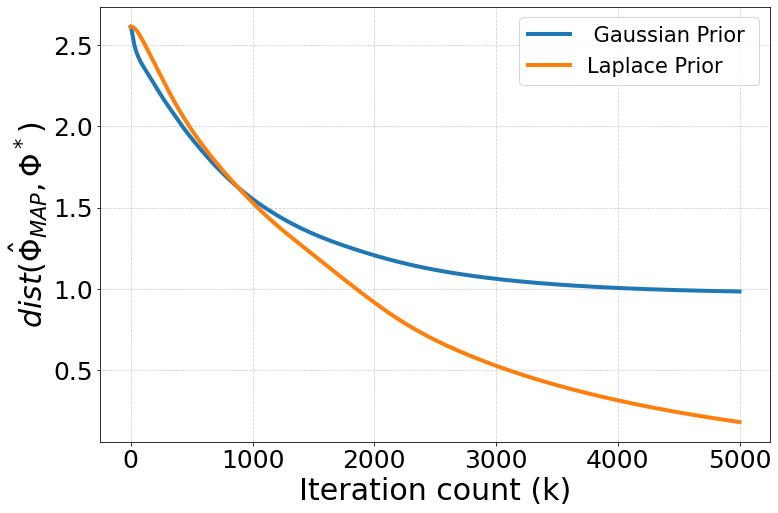

In [46]:
# Create a plot to show the convergence of the Gibbs Sampler (Log-joint vs iterations)
fig, ax = plt.subplots(figsize=(12,8))


# Plot the data
ax.plot(list(range(int(K))), Error_CAMAP_1, label=r' Gaussian Prior ', linestyle='-', linewidth=4)
ax.plot(list(range(int(K))), Error_CAMAP_1_s, label=r'Laplace Prior', linestyle='-', linewidth=4)

# Set labels and a title
ax.set_xlabel('Iteration count (k)',fontsize=30)
ax.set_ylabel(r'$dist(\hat{\Phi}_{MAP},\Phi^*)$',fontsize=30)
ax.tick_params(axis='both', labelsize=25)
plt.legend()
handles, labels = plt.gca().get_legend_handles_labels()
handles = handles[:4]  
labels = labels[:4] 
plt.legend(handles=handles, labels=labels,fontsize=21)

# Customize the grid
ax.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()